# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

Цель - построить модель с максимально большим значением *accuracy*. 

## Открытие и изучение файла

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

from joblib import dump

In [2]:
df = pd.read_csv('users_behavior.csv') # прочитаем csv-файл

In [3]:
df.head() # Выведем первые 5 строчек датафрейма df на экран.

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info() # Выведем основную информацию о датафрейме с помощью метода info().

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Согласно документации к данным:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [6]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Изменим тип в столбцах calls и messages на целочисленный. 

In [7]:
df['calls'] = df['calls'].astype('int')

In [8]:
df['messages'] = df['messages'].astype('int')

Итак, в таблице 5 столбцов и 3214 строки. Типы данных в столбцах — float64(2), int64(3). Количество значений в столбцах не различается, значит пропусков нет. 

Целевой признак - это 'is_ultra' (каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0). Если целевой признак категориальный, то решается задача
классификации. У нас категории всего две, значит речь идёт о бинарной (двоичной) классификации. Посмотрим на сбалансированность классов целевого признака. 


In [9]:
print('Доля класса «Ультра» составляет: {:.1%}'.format(len(df[(df['is_ultra'] == 1)]) / len(df)))
print('Доля класса «Смарт» составляет: {:.1%}'.format(len(df[(df['is_ultra'] == 0)]) / len(df)))

Доля класса «Ультра» составляет: 30.6%
Доля класса «Смарт» составляет: 69.4%


Видно, что классы в целевом признаке не сбалансированы. </b>


## Разбиение данных на выборки

Данные нужно разбить на три части: обучающую, валидационную и тестовую. Исходные данные разобъем в соотношении 3:1:1. 

Объявим переменные с признаками (features) и целевым признаком (target). 

In [10]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra'] 

In [11]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
test_size=0.4, random_state=12345, stratify = target) # отделим 60% данных для обучающей выборки
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid,
test_size=0.5, random_state=12345, stratify = target_valid) # разобъем по 20% данных для тестовой и валидационной выборок

In [12]:
print(features_train.shape[0]) # Выведим на экран размеры 
print(features_valid.shape[0])
print(features_test.shape[0])

1928
643
643


## Исследование модели

**Модель DecisionTreeClassifier - классификатор дерева решений**

In [13]:
best_depth = 0
best_samples_split = 0
best_samples_leaf = 0
best_result = 0
for depth in range(1,20):
    for samples_split in range (2,10):
        for samples_leaf in range (1,10):
            model_dr = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_split = samples_split,
            min_samples_leaf = samples_leaf) # обучим модель с заданными параметрами
            model_dr.fit(features_train, target_train) # обучим модель на тренировочной выборке
            predictions_valid = model_dr.predict(features_valid) # получим предсказания модели
            result = accuracy_score(target_valid, predictions_valid) # посчитаем качество модели на валидационной выборке
            #print("max_depth =", depth, ": ", end='')
            #print(result)  
            if result > best_result:
                best_depth = depth
                best_samples_split = samples_split
                best_samples_leaf = samples_leaf
                best_result = result 
print('Accuracy лучшей модели:', best_result)
print('Глубина дерева =', best_depth, 'min_samples_split =', best_samples_split, 'min_samples_leaf =', best_samples_leaf)

Accuracy лучшей модели: 0.80248833592535
Глубина дерева = 7 min_samples_split = 2 min_samples_leaf = 9


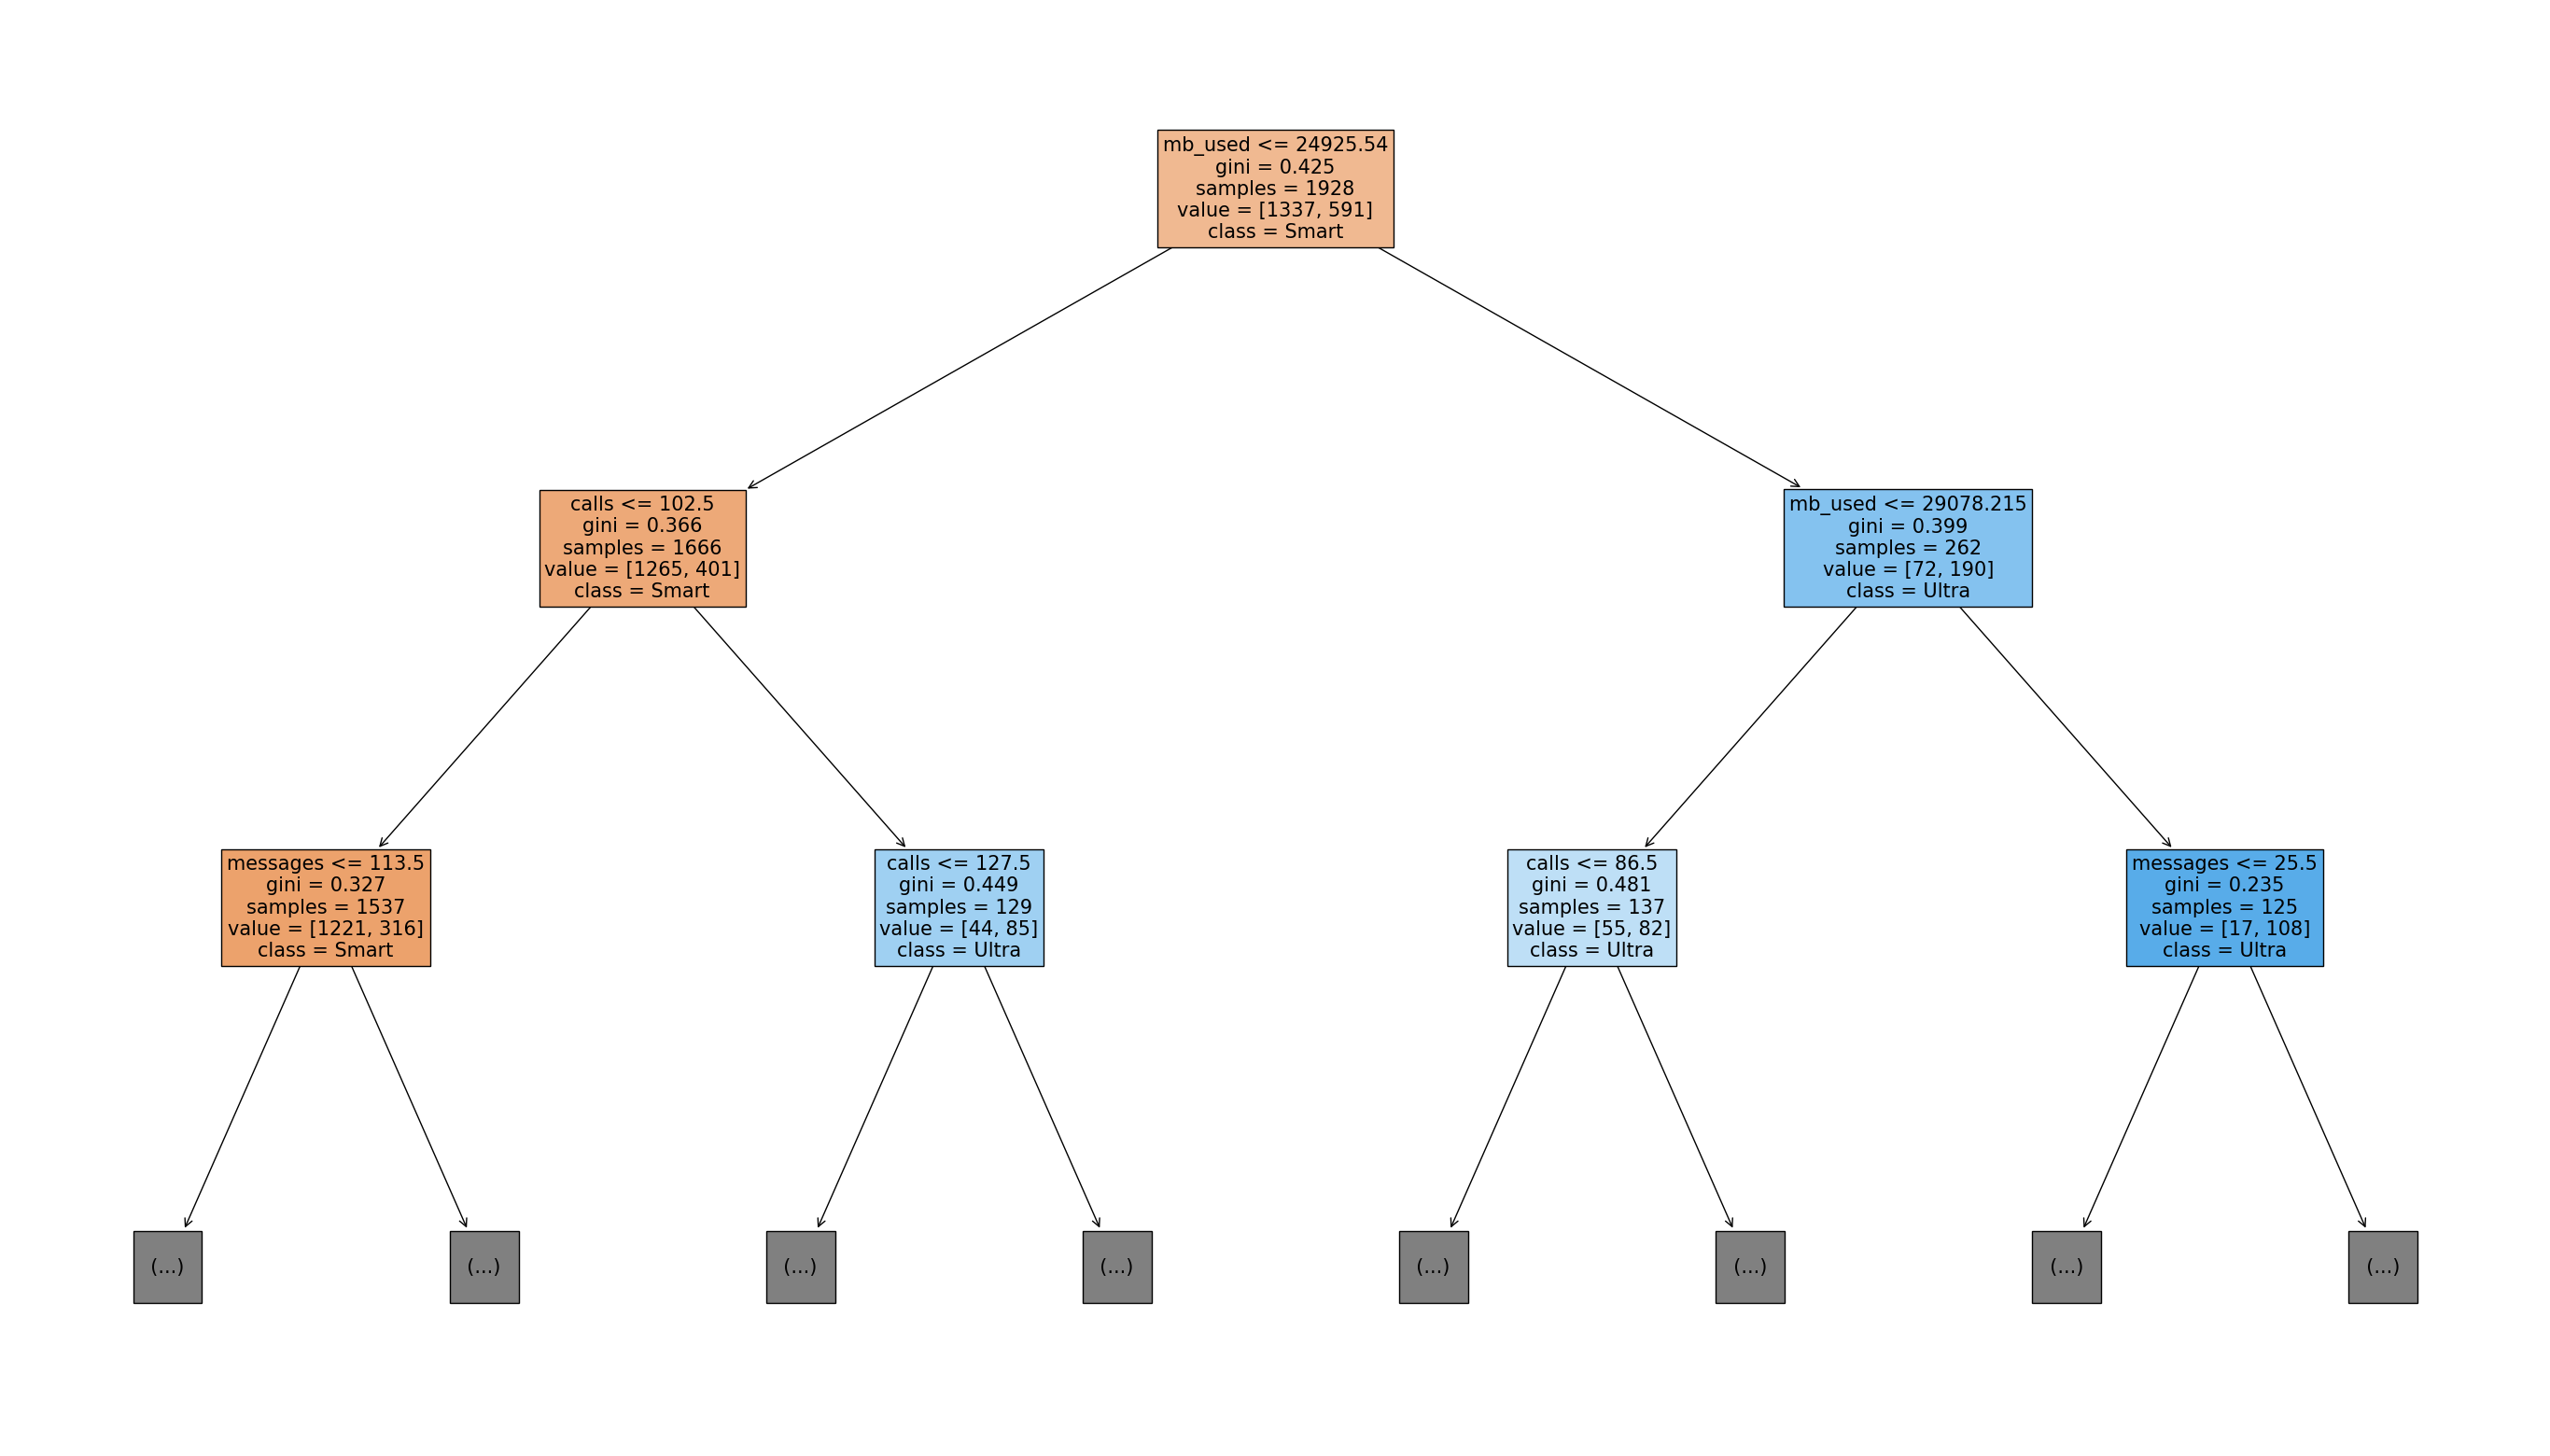

In [14]:
fig = plt.figure(figsize=(35, 20))
_ = tree.plot_tree(
    model_dr,  
    feature_names=list(features_train.columns.values),  
    class_names=['Smart', 'Ultra'],
    filled=True,
    fontsize=15,
    max_depth=2  
)

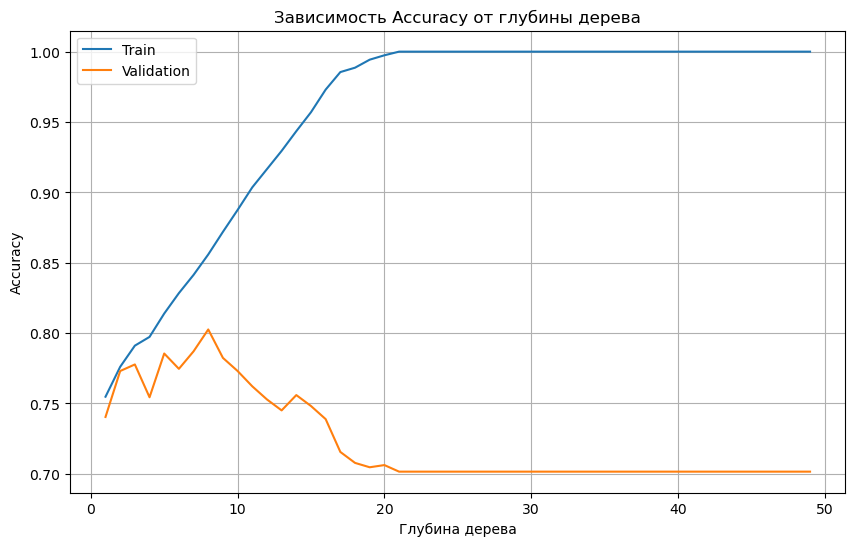

In [15]:
train_scores = []
valid_scores = []
max_depth = range(1,50)
for depth in max_depth:
    model_dr = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model_dr.fit(features_train, target_train) 
    train_scores.append(model_dr.score(features_train, target_train))
    valid_scores.append(model_dr.score(features_valid, target_valid))
plt.figure(figsize=(10, 6))
plt.plot(max_depth, train_scores, label='Train')
plt.plot(max_depth, valid_scores, label='Validation')
plt.title('Зависимость Accuracy от глубины дерева')
plt.xlabel('Глубина дерева')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

При достижении определенной глубины деревьев наша доля верных ответов выходит на асимптоту. Увеличение глубины дерева приводит к переобучению модели. Точность на валидационной выборке растет до глубины 8, а потом снижается в связи с переобучением, поэтмоу оптимальная глубина дерева равна 8.  На обучающей выборке точность достигает 1 при глубине 20 и модель перестает изменяться.

**Алгоритм классификации RandomForestClassifier - классификатор случайного леса**

In [16]:
%%time
best_est = 0
best_result = 0
for est in range(1, 20):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid)
    result = model.score(features_valid, target_valid) 
    #print("max_estimators =", est, ": ", end='')
    #print(result)  
    if result > best_result:
        best_est = est
        best_result = result 
print("Accuracy лучшей модели:", best_result)

Accuracy лучшей модели: 0.7931570762052877
CPU times: user 821 ms, sys: 38.2 ms, total: 859 ms
Wall time: 589 ms


In [17]:
%%time
best_est = 0
best_depth = 0
best_result = 0
for depth in range(1,20):
    for est in range(1, 50):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = model.score(features_valid, target_valid) 
        if result > best_result:
            best_est = est
            best_depth = depth
            best_result = result 
print("Accuracy лучшей модели:", best_result)
print('Глубина дерева =', best_depth, 'количество деревьев =', best_est)

Accuracy лучшей модели: 0.8227060653188181
Глубина дерева = 9 количество деревьев = 39
CPU times: user 45.7 s, sys: 2.57 s, total: 48.2 s
Wall time: 50.8 s


**Модель LogisticRegression - логистическая регрессия**

In [18]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model.fit(features_train, target_train) 
predictions = model.predict(features_valid)
result = model.score(features_valid, target_valid)
dump(model, 'model_9_1.joblib')
print("Accuracy лучшей модели:", result)

Accuracy лучшей модели: 0.7387247278382582


**Вывод:** 
- Accuracy лучшей модели DecisionTreeClassifier: 0.7869362363919129 при глубине дерева = 6, min_samples_split = 2, min_samples_leaf = 4.
- Accuracy лучшей модели RandomForestClassifier: 0.8087091757387247 при глубине дерева = 8 и количестве деревьев = 40.
- Accuracy лучшей модели LogisticRegression: 0.7107309486780715. 


Лучший результат показывает модель RandomForestClassifier с глубиной дерева = 8 и количеством деревьев = 40.

## Проверка модели на тестовой выборке

In [21]:
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=8)
model.fit(features_train, target_train)
result_test = model.score(features_test, target_test)
print("Accuracy модели на тестовой выборке:", result_test)

Accuracy модели на тестовой выборке: 0.8087091757387247


Удалось достичь accuracy не меньше 0.75

Мы построили модель с максимально большим значением accuracy. Можно подготовить презентацию результата согласно запросу.
В своих выводах не давать прямых указаний, ограничиться рекомендациями.

## Проверка модели на адекватность

Чтобы проверить модель на адекватность будем использовать DummyClassifier со стратегией 'most_frequent' - этот метод всегда возвращает наиболее часто встречающуюся метку класса в обучающем наборе. 
 DummyClassifier — это классификатор, который делает прогнозы, используя простые правила.

In [22]:
model_dummy = DummyClassifier(random_state=12345, strategy='most_frequent')
model_dummy.fit(features_train, target_train) 
result_dummy = model_dummy.score(features_test, target_test)
print("Accuracy модели на тестовой выборке c DummyClassifier:", result_dummy)
print("Accuracy модели на тестовой выборке:", result_test)

Accuracy модели на тестовой выборке c DummyClassifier: 0.6936236391912908
Accuracy модели на тестовой выборке: 0.8087091757387247


**Вывод:**

Таким образом, мы изучили данные о поведении клиентов, которые перешли на эти тарифы «Смарт» или «Ультра». 

Разбили данные на на три части: обучающую, валидационную и тестовую в соотношении 3:1:1. 

Построили следующие модели для задачи классификации: DecisionTreeClassifier - классификатор дерева решений, RandomForestClassifier - классификатор случайного леса, LogisticRegression - логистическая регрессия. 

Лучший результат показала модель RandomForestClassifier - Accuracy = 0.8087091757387247 с глубиной дерева = 8 и количеством деревьев = 40.

Проверили модель на тестовой выборке. Определили, что доля правильных ответов выше 0.75. 

Проверили модели на адекватность с помощью DummyClassifier.